# Fixed-width Interval Components

Split the original data into fixed-width intervals and consider the components of the aggregate network in each interval.

Further analysis is conducted in ``main.ipynb``.

In [1]:
from eventgraphs import EventGraph

%pylab inline
import pandas as pd
from sklearn.preprocessing import Normalizer

Populating the interactive namespace from numpy and matplotlib


In [4]:
PLOT_STYLE = {'lines.linewidth':2,
          'font.size':16,
          'xtick.labelsize':16,
          'ytick.labelsize':16,
          'axes.labelsize' : 16,
          'mathtext.fontset':'cm',
          'mathtext.rm' :'serif',
          'text.usetex':False
         }

In [2]:
data = pd.read_csv('./data/twitter_24h.csv', header=0)

In [3]:
intervals = {}
interval_width = 535.763596809282
for ix, start in enumerate(np.arange(0, 86400, interval_width)):
    print(ix, end='\r')
    interval = data[(data.time>=start) & (data.time<start+interval_width)]
    eg = EventGraph.from_pandas_eventlist(interval, graph_rules='teg')
    eg.build()
    eg.calculate_edge_motifs(edge_type='type')
    components = eg.connected_components(min_size=5)
    intervals[ix] = components
len(intervals)

162

In [22]:
components = {}
counter = 0
for cmps in intervals.values():
    for c in cmps.values():
        components[counter] = c
        counter +=1
        
len(components)

5912

In [13]:
from eventgraphs.clustering import generate_features, FEATURE_SPEC
FEATURE_SPEC['event_graph_features'][1]['kwargs'] = {'miller_correct':False, 'k':24}
FEATURE_SPEC['event_graph_features'][2]['kwargs'] = {'miller_correct':False, 'divisions':10}

features, scale_features = generate_features(components, feature_spec=FEATURE_SPEC)

In [14]:
# Rescale
rs_features = Normalizer().fit_transform(features)
rs_features = pd.DataFrame(rs_features, index=features.index, columns=features.columns)

In [15]:
from sklearn.metrics import silhouette_score
from eventgraphs.clustering import find_clusters

scores = {}
for cluster_size in range(2,31):
    clusters, cluster_centers = find_clusters(rs_features, max_clusters=cluster_size, metric='euclidean')
    scores[cluster_size] = silhouette_score(rs_features, clusters)
scores = pd.Series(scores)

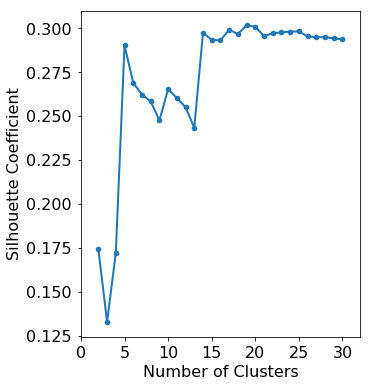

In [28]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(5,6))
    ax = fig.add_subplot(111)

    scores.plot(marker='o', ax=ax)

    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Silhouette Coefficient")

    ax.set_xlim(0,32)

    ax.set_xticks(np.arange(0,33,5));

In [20]:
max_clusters = 5
clusters, cluster_centers = find_clusters(rs_features, max_clusters=max_clusters, metric='euclidean')

In [18]:
from eventgraphs.clustering import reduce_feature_dimensionality
from eventgraphs.plotting import plot_component_embedding

X, (tsne, _) = reduce_feature_dimensionality(rs_features, 
                                             ndim=2, 
                                             method='tsne', 
                                             return_scalers=True, 
                                             **dict(random_state=0, 
                                                  verbose=True, 
                                                  learning_rate=500),)

Y, PCA = reduce_feature_dimensionality(rs_features, 
                                       ndim=3, 
                                       method='pca', 
                                       return_scalers=True,) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5912 samples in 0.040s...
[t-SNE] Computed neighbors for 5912 samples in 0.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5912
[t-SNE] Computed conditional probabilities for sample 2000 / 5912
[t-SNE] Computed conditional probabilities for sample 3000 / 5912
[t-SNE] Computed conditional probabilities for sample 4000 / 5912
[t-SNE] Computed conditional probabilities for sample 5000 / 5912
[t-SNE] Computed conditional probabilities for sample 5912 / 5912
[t-SNE] Mean sigma: 0.008141
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.498314
[t-SNE] Error after 1000 iterations: 0.810622


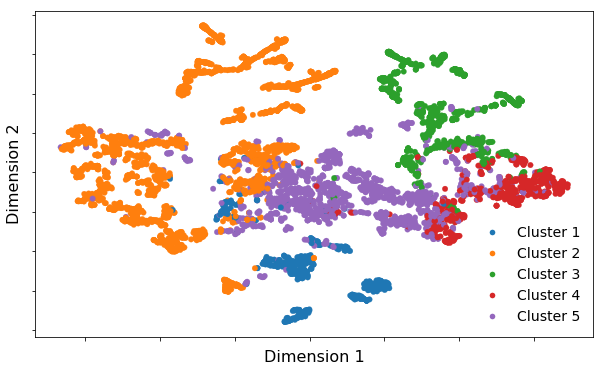

In [21]:
with plt.style.context(['seaborn-paper', PLOT_STYLE, {'legend.fontsize':14,
                                                      'legend.frameon':False}]):

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    ax = plot_component_embedding(X, clusters=clusters, ax=ax);